In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

     |████████████████████████████████| 428 kB 6.5 MB/s eta 0:00:01
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# AIM
## To classify the images into 
### F Fatty
### G Fatty-glandular
### D Dense-glandular

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [2]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [3]:
info=pd.read_csv("../input/mias-mammography/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna(0)

0      B
1      B
2      0
3      0
4      B
      ..
325    0
326    0
327    0
328    0
329    0
Name: SEVERITY, Length: 330, dtype: object

<AxesSubplot:ylabel='CLASS'>

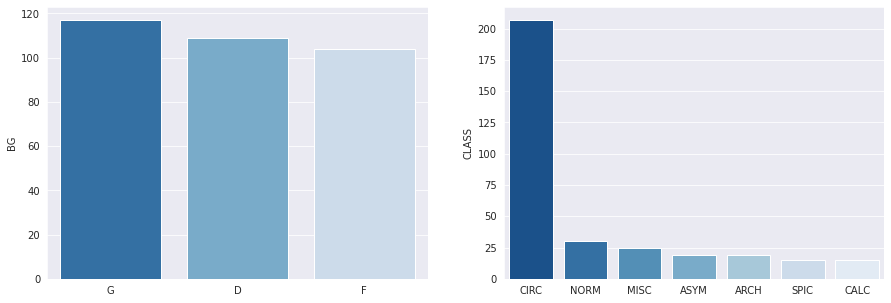

In [4]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=info.BG.unique(),y=info.BG.value_counts(),palette='Blues_r',ax=ax1)
sns.barplot(x=info.CLASS.unique(),y=info.CLASS.value_counts(),palette='Blues_r',ax=ax2)


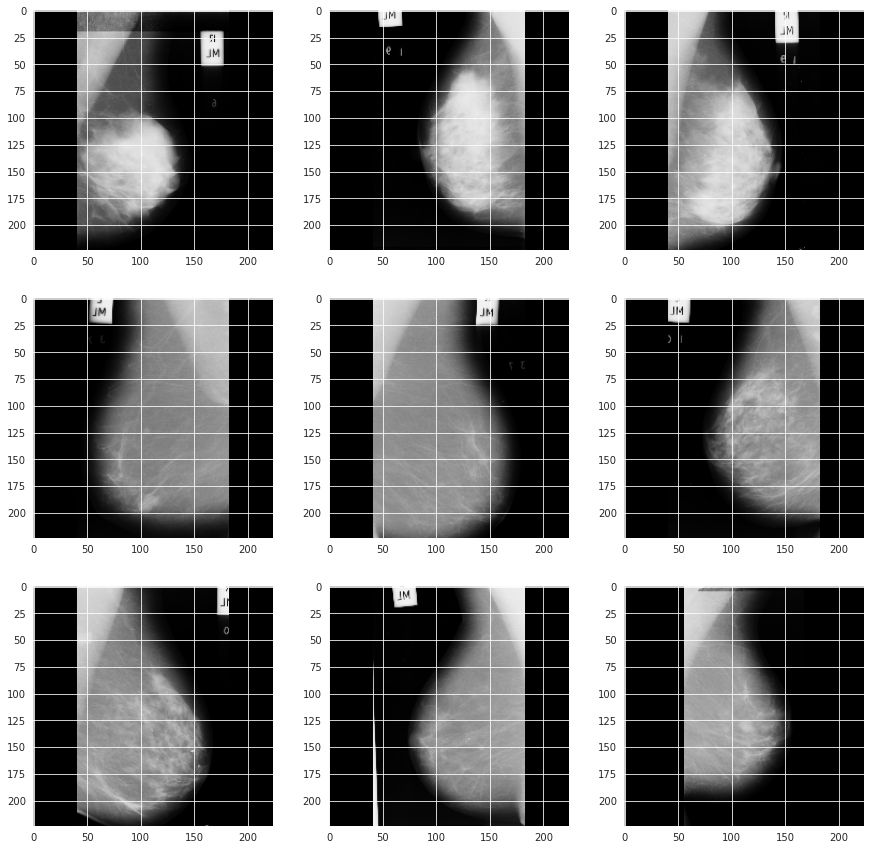

In [5]:
from PIL import Image
import glob
x= []
for filename in sorted(glob.glob("../input/mias-mammography/all-mias/*.pgm")): 
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [6]:
# Image Augmentation
no_angles = 360
url = '/kaggle/input/mias-mammography/all-mias/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

In [7]:
# train_test_split_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# val_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# test_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) 
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)


In [8]:
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))    

def read_lable():
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>1:
            if (words[1] == 'G'):
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 2
            if (words[1] == 'D'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 1
            if (words[1] == 'F'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 0
            
    return (info)

In [9]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys() 
#del lable_info['Truth-Data:']
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading images
10143 3042 1305


In [10]:
#Callbacks
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
nClasses=3

# InceptionResNetV2

In [11]:
base_Neural_Net= InceptionResNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

219062272/219055592 [==============================] - 1s 0us/step


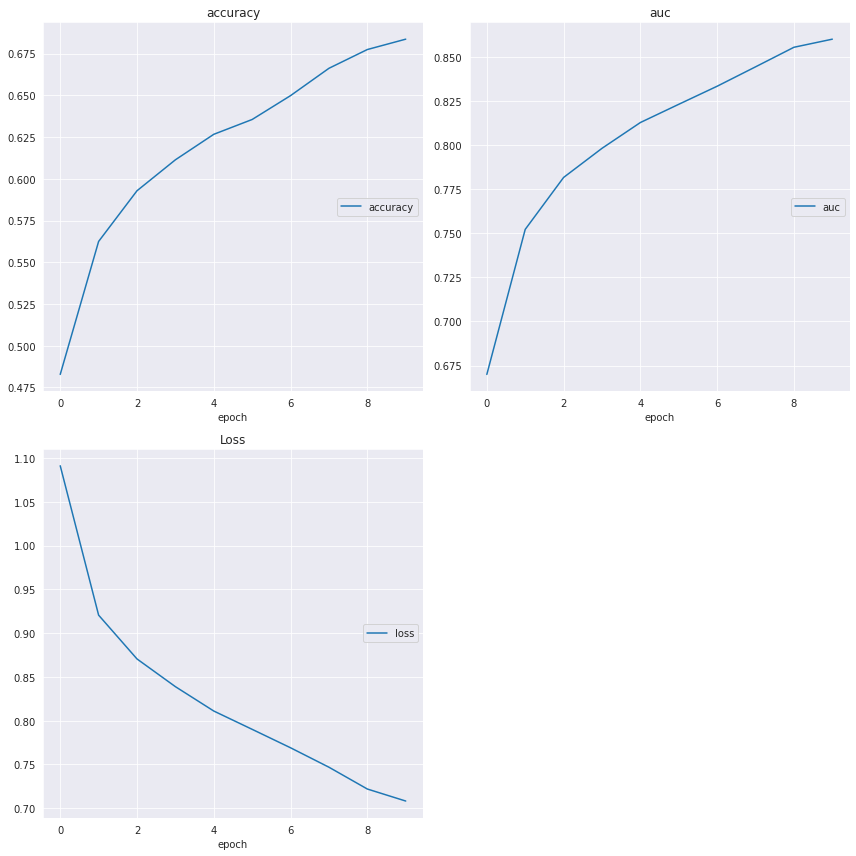

accuracy
	accuracy         	 (min:    0.483, max:    0.684, cur:    0.684)
auc
	auc              	 (min:    0.670, max:    0.860, cur:    0.860)
Loss
	loss             	 (min:    0.708, max:    1.091, cur:    0.708)


In [12]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [13]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 18s 76ms/step - loss: 0.6639 - accuracy: 0.7074 - auc: 0.8799


[0.6639047265052795, 0.7074293494224548, 0.8798699378967285]

In [14]:
print("Performance Report:")
y_pred6=model.predict_classes(x_test)
y_test6=[np.argmax(x) for x in y_test]
y_pred_prb6=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test6, y_pred6),4))
print('Precision score is :', np.round(metrics.precision_score(y_test6, y_pred6, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test6,y_pred6, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test6, y_pred6, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test6, y_pred_prb6,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test6, y_pred6,target_names=target))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test6, y_pred6),4))

Performance Report:
Accuracy score is : 0.7241
Precision score is : 0.7276
Recall score is : 0.7241
F1 Score is : 0.725
ROC AUC Score is : 0.8777
		Classification Report:
               precision    recall  f1-score   support

           G       0.73      0.74      0.74       392
           F       0.79      0.72      0.76       461
           D       0.66      0.71      0.68       452

    accuracy                           0.72      1305
   macro avg       0.73      0.73      0.73      1305
weighted avg       0.73      0.72      0.73      1305

Cohen Kappa Score: 0.5855


# Inception_V3

In [15]:
base_Neural_Net= InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


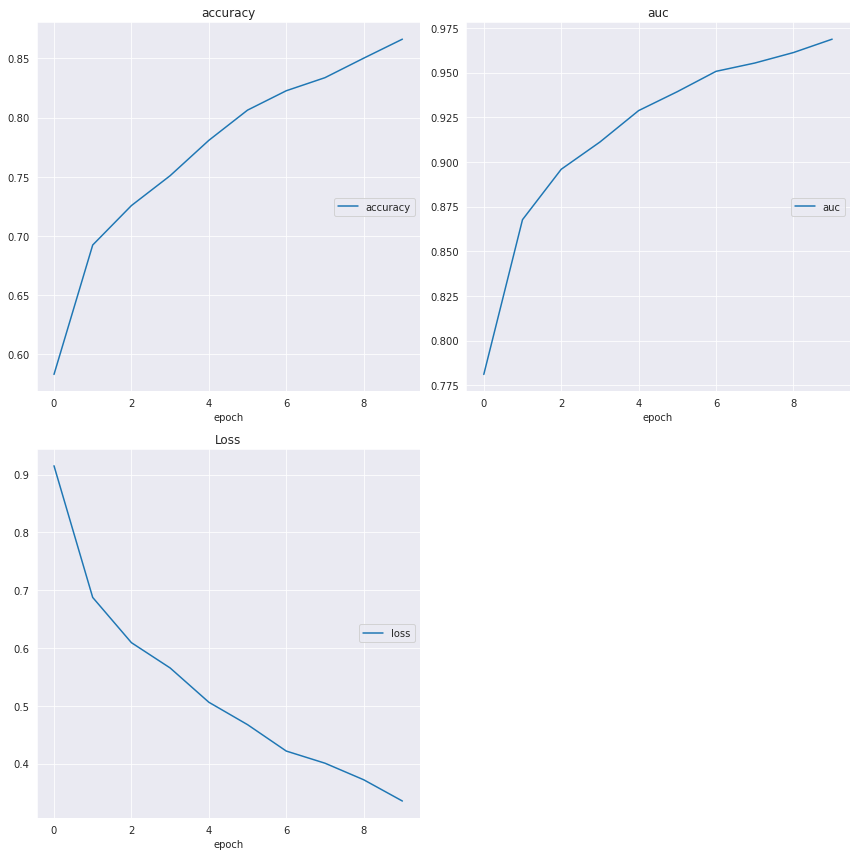

accuracy
	accuracy         	 (min:    0.583, max:    0.866, cur:    0.866)
auc
	auc              	 (min:    0.781, max:    0.969, cur:    0.969)
Loss
	loss             	 (min:    0.335, max:    0.915, cur:    0.335)


In [16]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [17]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 8s 33ms/step - loss: 0.5033 - accuracy: 0.8116 - auc: 0.9398


[0.5032883286476135, 0.8116371035575867, 0.9398367404937744]

In [18]:
print("Performance Report:")
y_pred7=model.predict_classes(x_test)
y_test7=[np.argmax(x) for x in y_test]
y_pred_prb7=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test7, y_pred7),4))
print('Precision score is :', np.round(metrics.precision_score(y_test7, y_pred7, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test7,y_pred7, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test7, y_pred7, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test7, y_pred_prb7,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test7, y_pred7,target_names=target))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test7, y_pred7),4))

Performance Report:
Accuracy score is : 0.8023
Precision score is : 0.8025
Recall score is : 0.8023
F1 Score is : 0.8019
ROC AUC Score is : 0.9346
		Classification Report:
               precision    recall  f1-score   support

           G       0.85      0.90      0.87       392
           F       0.83      0.77      0.80       461
           D       0.74      0.75      0.74       452

    accuracy                           0.80      1305
   macro avg       0.80      0.81      0.81      1305
weighted avg       0.80      0.80      0.80      1305

Cohen Kappa Score: 0.7031


# DenseNet169

In [11]:
base_Neural_Net=DenseNet169(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

51879936/51877672 [==============================] - 1s 0us/step


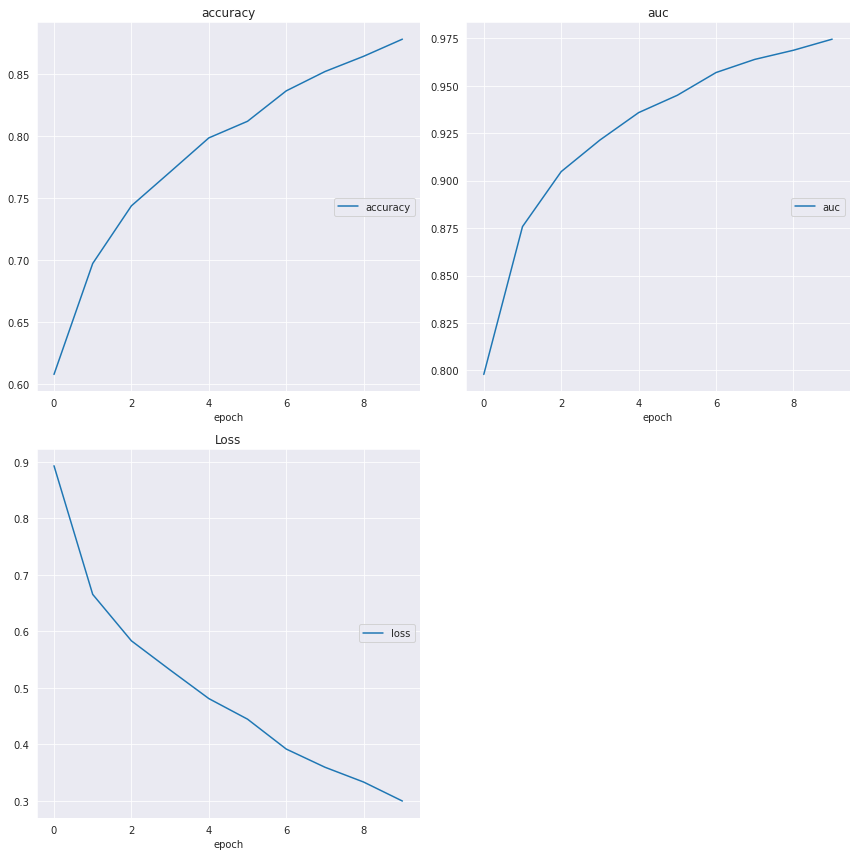

accuracy
	accuracy         	 (min:    0.608, max:    0.878, cur:    0.878)
auc
	auc              	 (min:    0.798, max:    0.975, cur:    0.975)
Loss
	loss             	 (min:    0.300, max:    0.893, cur:    0.300)


In [12]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [13]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 12s 47ms/step - loss: 0.4368 - accuracy: 0.8218 - auc: 0.9489


[0.43676477670669556, 0.82182776927948, 0.9489407539367676]

In [14]:
print("Performance Report:")
y_pred10=model.predict_classes(x_test)
y_test10=[np.argmax(x) for x in y_test]
y_pred_prb10=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test10, y_pred10),4))
print('Precision score is :', np.round(metrics.precision_score(y_test10, y_pred10, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test10,y_pred10, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test10, y_pred10, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test10, y_pred_prb10,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test10, y_pred10),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test10, y_pred10,target_names=target))


Performance Report:
Accuracy score is : 0.8253
Precision score is : 0.8243
Recall score is : 0.8253
F1 Score is : 0.8241
ROC AUC Score is : 0.9494
Cohen Kappa Score: 0.7377
		Classification Report:
               precision    recall  f1-score   support

           G       0.83      0.90      0.87       392
           F       0.85      0.85      0.85       461
           D       0.79      0.74      0.76       452

    accuracy                           0.83      1305
   macro avg       0.82      0.83      0.83      1305
weighted avg       0.82      0.83      0.82      1305



# DesneNet121

In [16]:
base_Neural_Net=DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

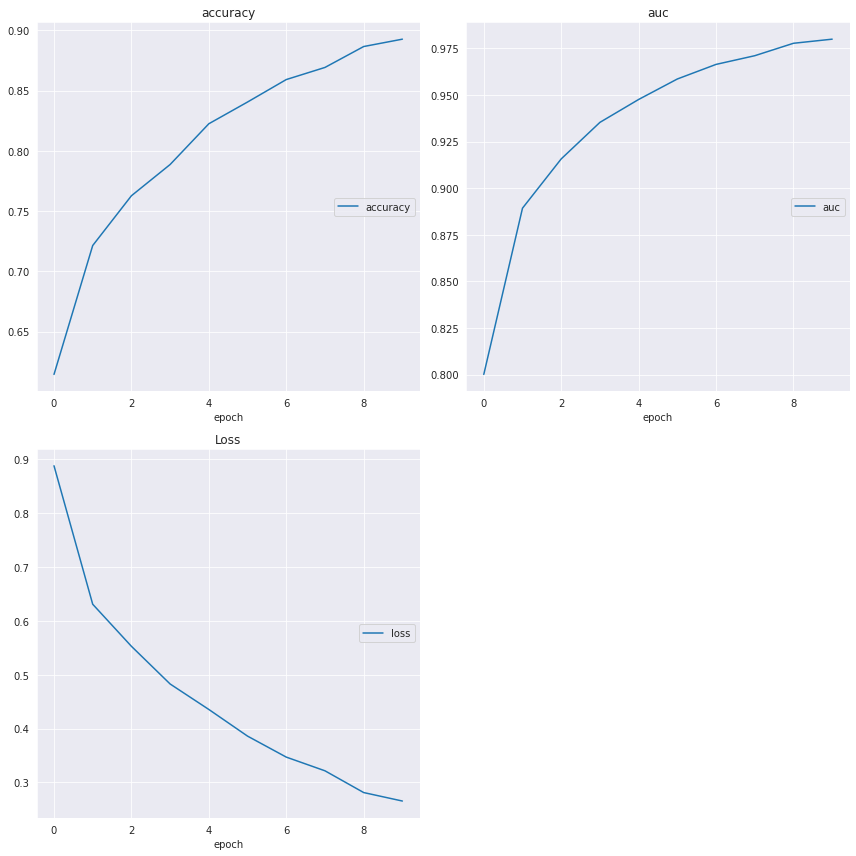

accuracy
	accuracy         	 (min:    0.614, max:    0.893, cur:    0.893)
auc
	auc              	 (min:    0.800, max:    0.980, cur:    0.980)
Loss
	loss             	 (min:    0.265, max:    0.888, cur:    0.265)


In [17]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [18]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 8s 34ms/step - loss: 0.3769 - accuracy: 0.8524 - auc: 0.9613


[0.37691664695739746, 0.8523997664451599, 0.9612975120544434]

In [19]:
print("Performance Report:")
y_pred11=model.predict_classes(x_test)
y_test11=[np.argmax(x) for x in y_test]
y_pred_prb11=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test11, y_pred11),4))
print('Precision score is :', np.round(metrics.precision_score(y_test11, y_pred11, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test11,y_pred11, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test11, y_pred11, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test11, y_pred_prb11,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test11, y_pred11),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test11, y_pred11,target_names=target))


Performance Report:
Accuracy score is : 0.8536
Precision score is : 0.8533
Recall score is : 0.8536
F1 Score is : 0.8533
ROC AUC Score is : 0.9582
Cohen Kappa Score: 0.7801
		Classification Report:
               precision    recall  f1-score   support

           G       0.86      0.89      0.88       392
           F       0.88      0.87      0.87       461
           D       0.82      0.80      0.81       452

    accuracy                           0.85      1305
   macro avg       0.85      0.86      0.85      1305
weighted avg       0.85      0.85      0.85      1305



# MobileNetV2

In [11]:
base_Neural_Net=MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


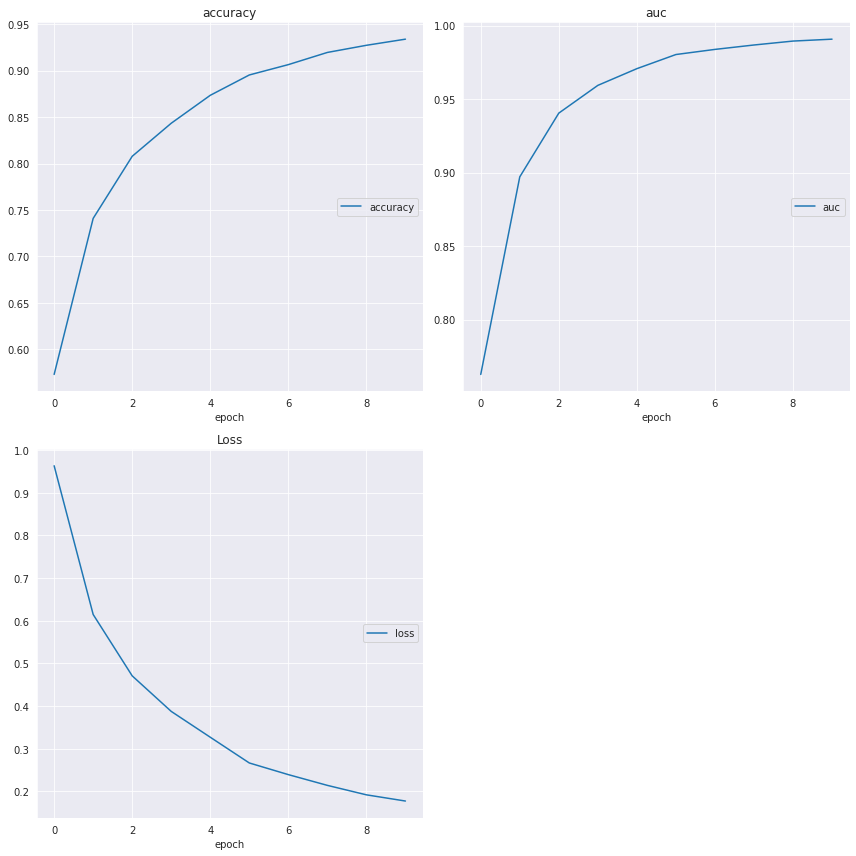

accuracy
	accuracy         	 (min:    0.573, max:    0.934, cur:    0.934)
auc
	auc              	 (min:    0.763, max:    0.991, cur:    0.991)
Loss
	loss             	 (min:    0.177, max:    0.963, cur:    0.177)


In [12]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [13]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 4s 17ms/step - loss: 0.5836 - accuracy: 0.8271 - auc: 0.9386


[0.5835900902748108, 0.8270874619483948, 0.9385854005813599]

In [14]:
print("Performance Report:")
y_pred12=model.predict_classes(x_test)
y_test12=[np.argmax(x) for x in y_test]
y_pred_prb12=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test12, y_pred12),4))
print('Precision score is :', np.round(metrics.precision_score(y_test12, y_pred12, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test12,y_pred12, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test12, y_pred12, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test12, y_pred_prb12,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test12, y_pred12),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test12, y_pred12,target_names=target))


Performance Report:
Accuracy score is : 0.8169
Precision score is : 0.8172
Recall score is : 0.8169
F1 Score is : 0.8163
ROC AUC Score is : 0.9408
Cohen Kappa Score: 0.7251
		Classification Report:
               precision    recall  f1-score   support

           G       0.80      0.86      0.83       392
           F       0.85      0.84      0.85       461
           D       0.80      0.75      0.78       452

    accuracy                           0.82      1305
   macro avg       0.82      0.82      0.82      1305
weighted avg       0.82      0.82      0.82      1305



# VGG-16

In [15]:
base_Neural_Net=VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


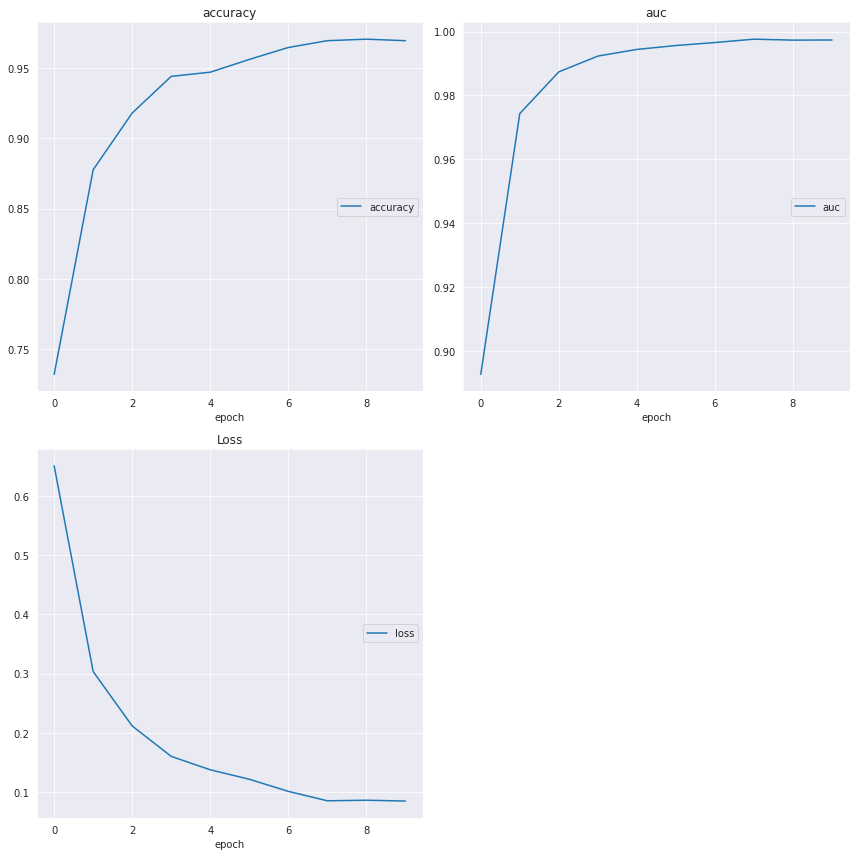

accuracy
	accuracy         	 (min:    0.732, max:    0.970, cur:    0.969)
auc
	auc              	 (min:    0.893, max:    0.998, cur:    0.997)
Loss
	loss             	 (min:    0.085, max:    0.651, cur:    0.085)


In [16]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [17]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 7s 37ms/step - loss: 0.2127 - accuracy: 0.9484 - auc: 0.9880


[0.21273624897003174, 0.9483892321586609, 0.9879827499389648]

In [18]:
print("Performance Report:")
y_pred13=model.predict_classes(x_test)
y_test13=[np.argmax(x) for x in y_test]
y_pred_prb13=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test13, y_pred13),4))
print('Precision score is :', np.round(metrics.precision_score(y_test13, y_pred13, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test13,y_pred13, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test13, y_pred13, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test13, y_pred_prb13,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test13, y_pred13),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test13, y_pred13,target_names=target))


Performance Report:
Accuracy score is : 0.9525
Precision score is : 0.9537
Recall score is : 0.9525
F1 Score is : 0.9527
ROC AUC Score is : 0.9893
Cohen Kappa Score: 0.9286
		Classification Report:
               precision    recall  f1-score   support

           G       0.97      0.96      0.96       392
           F       0.98      0.93      0.96       461
           D       0.92      0.97      0.94       452

    accuracy                           0.95      1305
   macro avg       0.95      0.95      0.95      1305
weighted avg       0.95      0.95      0.95      1305



# ResNet101

In [19]:
base_Neural_Net=ResNet101(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

171450368/171446536 [==============================] - 2s 0us/step


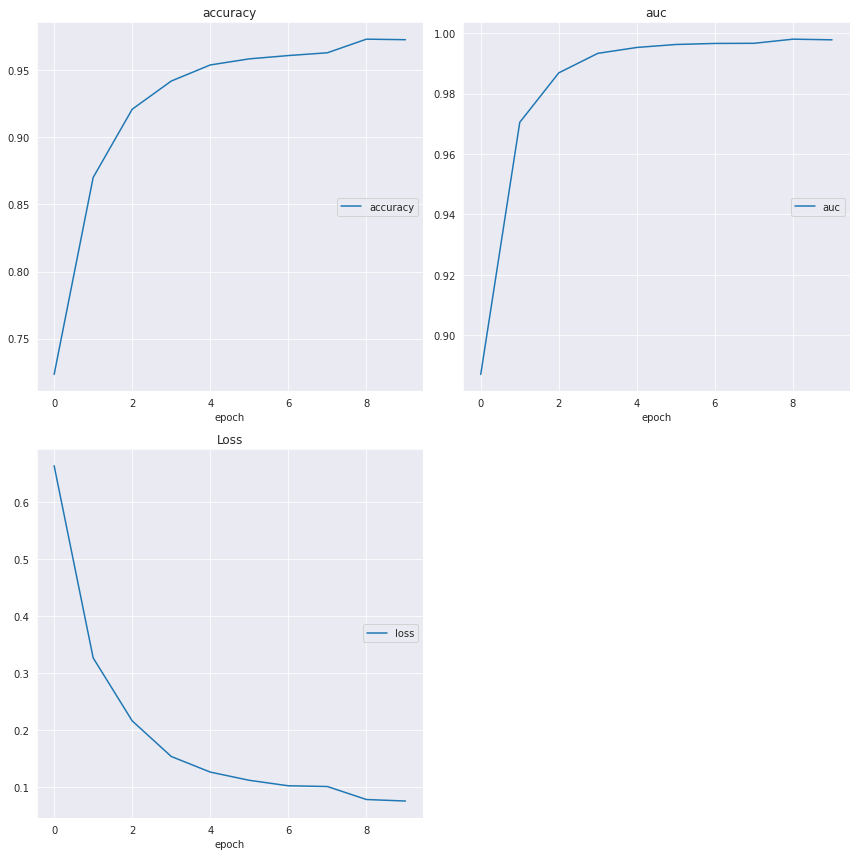

accuracy
	accuracy         	 (min:    0.723, max:    0.973, cur:    0.973)
auc
	auc              	 (min:    0.887, max:    0.998, cur:    0.998)
Loss
	loss             	 (min:    0.075, max:    0.663, cur:    0.075)


In [20]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [21]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 13s 54ms/step - loss: 0.1648 - accuracy: 0.9504 - auc: 0.9906


[0.16477052867412567, 0.9503616094589233, 0.9905756711959839]

In [22]:
print("Performance Report:")
y_pred14=model.predict_classes(x_test)
y_test14=[np.argmax(x) for x in y_test]
y_pred_prb14=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test14, y_pred14),4))
print('Precision score is :', np.round(metrics.precision_score(y_test14, y_pred14, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test14,y_pred14, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test14, y_pred14, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test14, y_pred_prb14,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test14, y_pred14),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test14, y_pred14,target_names=target))


Performance Report:
Accuracy score is : 0.951
Precision score is : 0.9513
Recall score is : 0.951
F1 Score is : 0.951
ROC AUC Score is : 0.9919
Cohen Kappa Score: 0.9262
		Classification Report:
               precision    recall  f1-score   support

           G       0.98      0.95      0.96       392
           F       0.94      0.97      0.96       461
           D       0.93      0.94      0.94       452

    accuracy                           0.95      1305
   macro avg       0.95      0.95      0.95      1305
weighted avg       0.95      0.95      0.95      1305

